In [1]:
#Set google drive
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········


ValueError: ignored

In [0]:
#Install miniconda and rdkit
!wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!time bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
!time conda install -q -y -c conda-forge rdkit
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

In [0]:
#Read smiles files
maxlen = 64
with open('/content/gdrive/My Drive/Colab Notebooks/smiles.txt') as f:
  smiles = f.readlines()[:]
  smiles = [s.strip() for s in smiles]
  smiles = [s.split()[1] for s in smiles]
  smiles = [s for s in smiles if len(s)<maxlen]

#Characters of smiles
all_smiles=''
for s in smiles: all_smiles+=s
chars = sorted(list(set(list(all_smiles))))
chars.append('X')
c_to_i = {c:i for i,c in enumerate(chars)}
print ('Max len:', maxlen)
print ('Number of chars:', len(chars))
print (chars)
print (c_to_i)

Max len: 64
Number of chars: 46
['#', '(', ')', '+', '-', '.', '/', '1', '2', '3', '4', '5', '6', '7', '=', '@', 'B', 'C', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'S', 'V', 'Z', '[', '\\', ']', 'a', 'c', 'e', 'g', 'i', 'l', 'n', 'o', 'r', 's', 'u', 'X']
{'#': 0, '(': 1, ')': 2, '+': 3, '-': 4, '.': 5, '/': 6, '1': 7, '2': 8, '3': 9, '4': 10, '5': 11, '6': 12, '7': 13, '=': 14, '@': 15, 'B': 16, 'C': 17, 'F': 18, 'G': 19, 'H': 20, 'I': 21, 'K': 22, 'L': 23, 'M': 24, 'N': 25, 'O': 26, 'P': 27, 'S': 28, 'V': 29, 'Z': 30, '[': 31, '\\': 32, ']': 33, 'a': 34, 'c': 35, 'e': 36, 'g': 37, 'i': 38, 'l': 39, 'n': 40, 'o': 41, 'r': 42, 's': 43, 'u': 44, 'X': 45}


In [0]:
#Calculate Morgan fingerprints and LogP of each molecule
from rdkit import Chem
from rdkit.Chem.Crippen import MolLogP
import numpy as np
import torch
import time

Y = []
num_data = 20000
st = time.time()
for s in smiles[:num_data]:
  m = Chem.MolFromSmiles(s)
  logp = MolLogP(m)
  Y.append(logp)
end = time.time()

print (f'Time:{(end-st):.3f}')

Time:13.930


In [0]:
#Dataset
from torch.utils.data import Dataset, DataLoader

class MolDataset(Dataset):
    def __init__(self, smiles, properties, c_to_i, maxlen):
      self.c_to_i = c_to_i
      self.maxlen = maxlen
      self.smiles = smiles
      self.properties = properties
      
    def __len__(self):
        return len(self.smiles)

    def __getitem__(self, idx):
        s = self.smiles[idx]
        s = s.ljust(self.maxlen, 'X')
        i = torch.from_numpy(np.array([c_to_i[c] for c in s]))
        sample = dict()
        sample['X'] = i
        sample['Y'] = self.properties[idx]
        return sample

In [0]:
#Model

import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvRegressor(torch.nn.Module):
  def __init__(self, n_channel=128, n_conv_layer = 10, kernel_size=3, n_char=46):
    super(ConvRegressor, self).__init__()
    self.conv = nn.ModuleList([nn.Conv1d(n_channel, n_channel, kernel_size, \
                          1, padding = kernel_size//2) \
                          for i in range(n_conv_layer)])
    self.dropout =  nn.ModuleList([nn.Dropout(p=0.5) \
                          for i in range(n_conv_layer)])    
    self.bn =  nn.ModuleList([nn.BatchNorm1D(num_features=n_channel) \
                          for i in range(n_conv_layer)])          
    self.fc = nn.Linear(maxlen*n_channel, 1)
    self.embedding = nn.Embedding(n_char, n_channel)

  def forward(self, x):

    x = self.embedding(x)
    x = x.permute((0,2,1))

   input_x = x
   for i,l in enumerate(self.conv):
      x = F.relu(l(x))
      x = self.bn[i](x)
      x = self.dropout[i](x)
      
      if i%3==2:
        x+=input_x
        input_x = x
              
    x = x.view(x.size(0), -1)  
    x = self.fc(x)    
    return x

In [0]:
#Train model
import time
lr = 1e-4
model = ConvRegressor(128, 10, 3, 46)

#Dataset
train_smiles = smiles[:19000]
test_smiles = smiles[19000:20000]
train_logp = Y[:19000]
test_logp = Y[19000:20000]
train_dataset = MolDataset(train_smiles, train_logp, c_to_i, maxlen)
test_dataset = MolDataset(test_smiles, test_logp, c_to_i, maxlen)

#Dataloader
train_dataloader = DataLoader(train_dataset, batch_size=128, num_workers=1)
test_dataloader = DataLoader(test_dataset, batch_size=128, num_workers=1)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
#optimizer = torch.optim.SGD(model.parameters(), lr=lr)

loss_fn = nn.MSELoss()
loss_list = []
st = time.time()


model = model.cuda()

for epoch in range(10):
  epoch_loss = []
  for i_batch, batch in enumerate(train_dataloader):
    x, y = batch['X'].cuda(), batch['Y'].cuda()
    x = x.long()
    y = y.float()
    pred = model(x)
    pred = pred.squeeze(-1)
    loss = loss_fn(pred, y)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    loss_list.append(loss.data.cpu().numpy())
    epoch_loss.append(loss.data.cpu().numpy())

  if True: print (epoch, np.mean(np.array(epoch_loss)))
end = time.time()
print ('Time:', end-st)

0 9.698315
1 8.726807
2 4.613754


KeyboardInterrupt: ignored

In [0]:
#Save model
fn = '/content/gdrive/My Drive/save.pt'
torch.save(model.state_dict(), fn)

FileNotFoundError: ignored

In [0]:
#Load model
model.load_state_dict(torch.load(fn))

Text(0, 0.5, 'Loss')

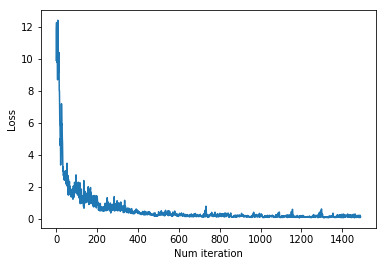

In [0]:
import matplotlib.pyplot as plt

plt.plot(loss_list)
plt.xlabel('Num iteration')
plt.ylabel('Loss')


In [0]:
#Test model
model.eval()
with torch.no_grad():
  y_pred_train, y_pred_test = [], []
  loss_train, loss_test = [], []
  pred_train, pred_test = [], []
  true_train, true_test = [], []

  
  for sample in train_dataloader:
    x, y = sample['X'].cuda(), sample['Y'].cuda().float()
    pred = model(x).squeeze(-1)
    pred_train.append(pred.data.cpu().numpy())
    true_train.append(y.data.cpu().numpy())

    loss_train.append(loss_fn(y, pred).data.cpu().numpy())
  
  for sample in test_dataloader:
    x, y = sample['X'].cuda(), sample['Y'].cuda().float()
    pred = model(x).squeeze(-1)
    pred_test.append(pred.data.cpu().numpy())
    true_test.append(y.data.cpu().numpy())
    loss_test.append(loss_fn(y, pred).data.cpu().numpy())

pred_train = np.concatenate(pred_train, -1)
pred_test = np.concatenate(pred_test, -1)
true_train = np.concatenate(true_train, -1)
true_test = np.concatenate(true_test, -1)
    
print ('Train loss:', np.mean(loss_train))
print ('Test loss:', np.mean(loss_test))

Train loss: 0.2043955
Test loss: 0.20735705


Text(0, 0.5, 'Pred')

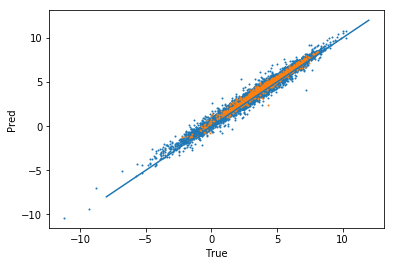

In [0]:

plt.scatter(true_train, pred_train, s=1)
plt.scatter(true_test, pred_test, s=1)

plt.plot([-8,12], [-8,12])
plt.xlabel('True')
plt.ylabel('Pred')
